# Multiplexed reconstruction

Example showing one way to use multiview-stitcher to stitch and align multiplexed datasets.

Notes:
- this should be straight-forward to generalize to 3D
- assumption: all cycles are registered to a reference cycle (registering cycle i to cycle i-1 requires some further parameter propagation not implemented here)
- output is one file per cycle currently

Ashlar example dataset: https://labsyspharm.github.io/ashlar/dataset.html.

Dependencies:
- multiview-stitcher >= 0.1.46
- ome-types

Questions: Marvin Albert (marvin.albert@bsse.ethz.ch)

In [1]:
# Ashlar example dataset

fn = "../image-datasets/ashlar/COLNOR69MW2-cycle-{cycle}.ome.tif"

cycles = [1, 2] # the first cycle serves as a reference cycle
reg_channel = "ch0"

In [2]:
import numpy as np

import dask.array as da
from dask import delayed
from dask import compute, diagnostics
from dask import config as dask_config

import tifffile
import ome_types

from multiview_stitcher import (
    registration,
    msi_utils,
)

# make mpl figures interactive
%matplotlib ipympl

Cycle:  1
Tile 0: position = {'y': 2147.3743, 'x': 8806.344}
Tile 1: position = {'y': 2147.3743, 'x': 9618.344}
Tile 2: position = {'y': 2147.3743, 'x': 10430.344}
Tile 3: position = {'y': 2147.3743, 'x': 11242.344}
Tile 4: position = {'y': 2147.3743, 'x': 12054.344}
Tile 5: position = {'y': 2147.3743, 'x': 12866.344}
Tile 6: position = {'y': 2147.3743, 'x': 13678.344}
Tile 7: position = {'y': 2147.3743, 'x': 14490.344}
Tile 8: position = {'y': 2147.3743, 'x': 15302.344}
Tile 9: position = {'y': 2147.3743, 'x': 16114.344}
Tile 10: position = {'y': 2147.3743, 'x': 16926.344}
Tile 11: position = {'y': 2147.3743, 'x': 17738.344}
Tile 12: position = {'y': 2147.3743, 'x': 18550.344}
Tile 13: position = {'y': 2147.3743, 'x': 19362.344}
Tile 14: position = {'y': 2147.3743, 'x': 20174.344}
Tile 15: position = {'y': 2147.3743, 'x': 20986.344}
Tile 16: position = {'y': 2147.3743, 'x': 21798.344}
Tile 17: position = {'y': 2147.3743, 'x': 22610.344}
Tile 18: position = {'y': 2147.3743, 'x': 23422.

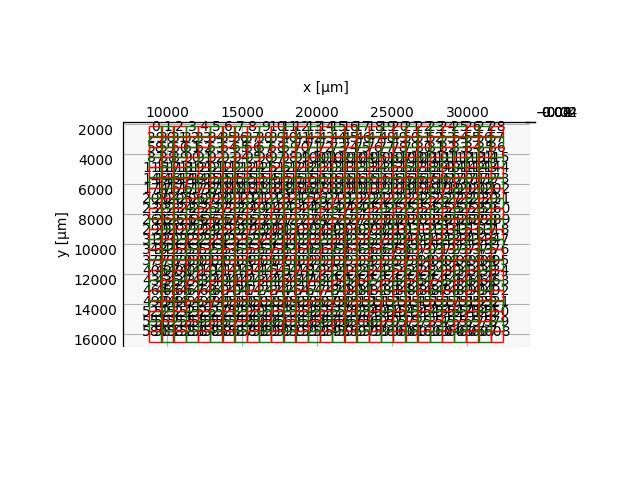

(<Figure size 640x480 with 1 Axes>, <Axes3D: ylabel='x [μm]', zlabel='y [μm]'>)

In [3]:
from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import vis_utils, msi_utils

sdims = ['y', 'x']

msimss = {}
for icycle, cycle in enumerate(cycles):
    print("Cycle: ", cycle)
    tf = tifffile.TiffFile(fn.format(cycle=cycle))
    ome_metadata = ome_types.from_tiff(fn.format(cycle=cycle))

    msims = []
    for itile in range(len(ome_metadata.images))[:]:
    # for itile in [0,1,29,30]: # small subset for testing
        pos = {dim: ome_metadata.images[itile].pixels.planes[0].__dict__['position_' + dim]
            for dim in sdims}
        # pos['y'] = -pos['y']
        
        print(f"Tile {itile}: position = {pos}")

        spacing = {dim: ome_metadata.images[itile].pixels.__dict__['physical_size_' + dim]
                for dim in sdims}
        shape = {dim: ome_metadata.images[itile].pixels.__dict__['size_' + dim]
                    for dim in sdims}
        dtype = np.dtype(ome_metadata.images[itile].pixels.type.value)
        data = da.from_delayed(
            delayed(tifffile.imread)(fn.format(cycle=cycle), series=itile),
            shape=[shape[dim] for dim in sdims],
            dtype=dtype
            )
        data = data[::-1] # flip y instead of inverting stage coordinates

        sim = si_utils.get_sim_from_array(
            # array=da.stack([data] * 2), # duplicate data to fake two channels
            array=da.stack([data] * 1), # duplicate data to fake two channels
            scale=spacing,
            translation=pos,
            dims=['c'] + sdims,
            # c_coords=["ch0", "ch1"],
            c_coords=["ch0"],
            transform_key='ome',
        )
        msim = msi_utils.get_msim_from_sim(
            sim, scale_factors=[]
        )

        msims.append(msim)
    
    msimss[cycle] = msims

vis_utils.plot_positions(msimss[cycles[0]], transform_key='ome')

## Stitch reference cycle

[########################################] | 100% Completed | 2.61 ss
[########################################] | 100% Completed | 323.08 s


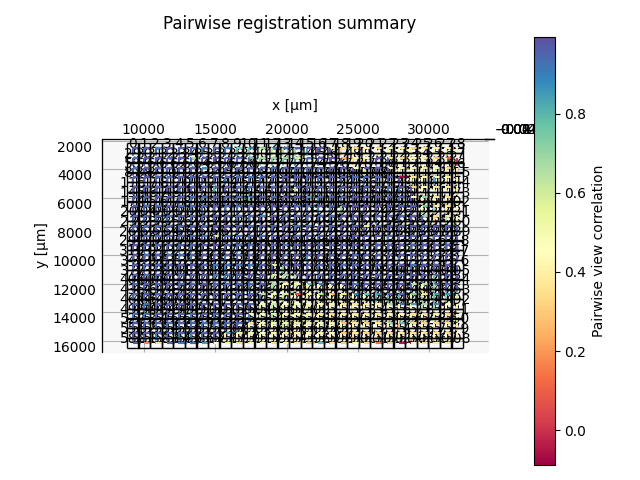

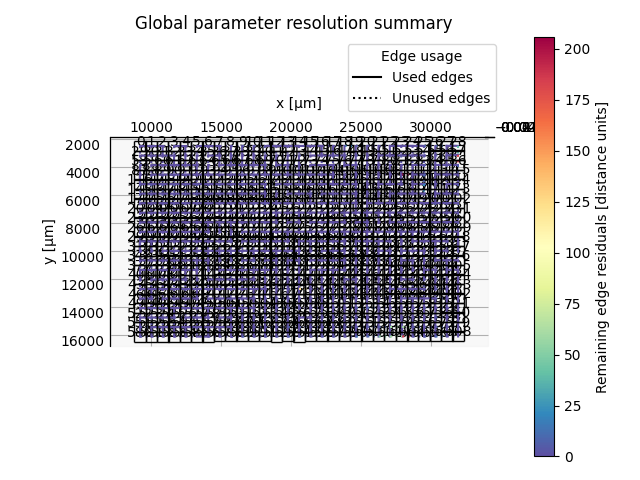

In [4]:
with diagnostics.ProgressBar():
    
    params_stitch = registration.register(
        msimss[cycles[0]],
        reg_channel=reg_channel,
        transform_key="ome",
        new_transform_key='stitch_reg',
        # registration_binning={dim: 2 for dim in sdims},
        plot_summary=True,
        groupwise_resolution_method='shortest_paths',
        pre_registration_pruning_method='keep_axis_aligned',
    )

## Align cycles

All cycles are registered against the previous cycle. Finally, all cycles are transformed into the coordinate system of the first cycle.

In [5]:
# # version 1: serial registration calls (good for a not too high number of large tiles)

# tiles = range(len(msimss[cycles[0]]))

# cycle_reg_params = {}

# for itile in tiles:

#     msi_utils.set_affine_transform(
#         msimss[cycles[0]][itile],
#         transform_key="coord_system_cycle_" + str(cycles[0]),
#         base_transform_key="ome",
#     )

#     for icycle, cycle in enumerate(cycles):
#         if not icycle: continue

#         fixed_cycle = cycles[icycle - 1]
#         moving_cycle = cycles[icycle]

#         fixed_msim = msimss[fixed_cycle][itile]
#         moving_msim = msimss[moving_cycle][itile]

#         msi_utils.set_affine_transform(
#             moving_msim,
#             transform_key="coord_system_cycle_" + str(cycles[0]),
#             base_transform_key="ome",
#         )

#         ## use either of the two registration code blocks below
#         ## (uncommenting both for sequential registrations will also work)

#         # # phase correlation registration
#         # params_phase = registration.register(
#         #     [fixed_msim, moving_msim],
#         #     reg_channel=reg_channel,
#         #     transform_key="coord_system_cycle_" + str(cycles[0]),
#         #     new_transform_key="coord_system_cycle_" + str(cycles[0]), # overwrite the previous transform key
#         #     groupwise_resolution_kwargs={
#         #         'reference_view': 0
#         #     }
#         # )

#         # rigid registration with ANTsPy
#         params_rot = registration.register(
#             [fixed_msim, moving_msim],
#             reg_channel=reg_channel,
#             transform_key="coord_system_cycle_" + str(cycles[0]),
#             new_transform_key="coord_system_cycle_" + str(cycles[0]), # overwrite the previous transform key
#             pairwise_reg_func=registration.registration_ANTsPy,
#             pairwise_reg_func_kwargs={
#                 'transform_type': ['translation', 'rigid'],
#                 "aff_metric": "mattes",
#                 # "aff_metric": "meansquares",
#                 # "verbose": True,
#                 # "aff_random_sampling_rate": 0.2,
#                 # "aff_iterations": (2000, 2000),
#                 # "aff_smoothing_sigmas": (1, 0),
#                 # "aff_shrink_factors": (2, 1),
#             },
#             groupwise_resolution_kwargs={
#                 'reference_view': 0,
#                 'transform': 'rigid'
#             },
#         )

#         print(f"Tile {itile}, cycle {moving_cycle} params: ", params_rot)


In [ ]:
# version 2: parallel registration calls (good for many small tiles)

tiles = range(len(msimss[cycles[0]]))

delayed_params = []

for itile in tiles:

    msi_utils.set_affine_transform(
        msimss[cycles[0]][itile],
        transform_key="coord_system_cycle_" + str(cycles[0]),
        base_transform_key="ome",
    )

    for icycle, cycle in enumerate(cycles):
        if not icycle: continue

        fixed_cycle = cycles[icycle - 1]
        moving_cycle = cycles[icycle]

        fixed_msim = msimss[fixed_cycle][itile]
        moving_msim = msimss[moving_cycle][itile]

        msi_utils.set_affine_transform(
            moving_msim,
            transform_key="coord_system_cycle_" + str(cycles[0]),
            base_transform_key="ome",
        )

        # use either of the two registration code blocks below
        # (uncommenting both for sequential registrations will NOT work in this version 2)

        # phase correlation registration
        with dask_config.set(scheduler='single-threaded'):
            params = delayed(registration.register)(
                [fixed_msim, moving_msim],
                reg_channel=reg_channel,
                transform_key="coord_system_cycle_" + str(cycles[0]),
                new_transform_key="coord_system_cycle_" + str(cycles[0]), # overwrite the previous transform key
                groupwise_resolution_kwargs={
                    'reference_view': 0
                }
            )

        # # rigid registration with ANTsPy
        # # uncomment code block below for only translation registration
        # with dask_config.set(scheduler='single-threaded'):
        #     params = delayed(registration.register)(
        #         [fixed_msim, moving_msim],
        #         reg_channel=reg_channel,
        #         transform_key="coord_system_cycle_" + str(cycles[0]),
        #         new_transform_key="coord_system_cycle_" + str(cycles[0]), # overwrite the previous transform key
        #         pairwise_reg_func=registration.registration_ANTsPy,
        #         pairwise_reg_func_kwargs={
        #             'transform_type': ['translation', 'rigid'],
        #             "aff_metric": "mattes",
        #             # "aff_metric": "meansquares",
        #             # "verbose": True,
        #             # "aff_random_sampling_rate": 0.2,
        #             # "aff_iterations": (2000, 2000),
        #             # "aff_smoothing_sigmas": (1, 0),
        #             # "aff_shrink_factors": (2, 1),
        #         },
        #         groupwise_resolution_kwargs={
        #             'reference_view': 0,
        #             'transform': 'rigid'
        #         },
        #     )

        delayed_params.append(params)

with diagnostics.ProgressBar():
    compute(delayed_params)

[########################################] | 100% Completed | 27m 36s


## Concatenate stitching and cycle alignment params

In [7]:
from multiview_stitcher import param_utils

for itile in tiles:
    stitch_params = msi_utils.get_transform_from_msim(
        msimss[cycles[0]][itile], transform_key='stitch_reg')
    for icycle, cycle in enumerate(cycles[1:]):

        msi_utils.set_affine_transform(
            msimss[cycle][itile],
            stitch_params,
            transform_key="stitch_reg",
            base_transform_key="coord_system_cycle_" + str(cycles[0]),
        )

## Fuse each cycle

In [8]:
from multiview_stitcher import fusion, misc_utils

output_fn = "/tmp/fused_cycle_threading41_{cycle}.ome.zarr"

output_stack_properties = fusion.calc_fusion_stack_properties(
    [msi_utils.get_sim_from_msim(msim) for msim in msimss[cycles[0]]],
    params=params_stitch,
    spacing=si_utils.get_spacing_from_sim(msi_utils.get_sim_from_msim(msimss[cycles[0]][0]))
)

fused_sims = {}
for cycle in cycles:
    fused_sims[cycle] = fusion.fuse(
        [msi_utils.get_sim_from_msim(msim) for msim in msimss[cycle]],
        transform_key='stitch_reg',
        # transform_key="coord_system_cycle_" + str(cycles[0]),
        # transform_key='ome',
        output_stack_properties=output_stack_properties,
        output_zarr_url=output_fn.format(cycle=cycle),
        zarr_options={
            'ome_zarr': True,
            'overwrite': True,
            'ngff_version': '0.4',
            'zarr_array_creation_kwargs': {
                'zarr_format': 2
                }
        },
        batch_options={
            'batch_func': misc_utils.process_batch_using_joblib,
            # 'batch_func': misc_utils.process_batch_using_ray,
            'n_batch': 100,
            'batch_func_kwargs': {
                'n_jobs': 6,
                # 'num_cpus': 10
                }
        }
    )

Fusing into a an output stack:
- shape:  {'t': 1, 'c': 1, 'y': 22080, 'x': 36293}
- spacing:  {'y': 0.6499999761581421, 'x': 0.6499999761581421}
- origin:  {'y': 2145.944300016617, 'x': 8795.68400052271}
Fusing 609 blocks in batches of 100...


  0%|          | 0/7 [00:00<?, ?it/s]/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 7/7 [20:56<00:00, 179.55s/it]  


Found existing resolution level 0...
Writing resolution level 1...


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Writing resolution level 2...


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Writing resolution level 3...


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


Writing resolution level 4...


100%|██████████| 1/1 [00:00<00:00, 24.03it/s]


Writing resolution level 5...


100%|██████████| 1/1 [00:00<00:00, 28.09it/s]


Writing resolution level 6...


100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Writing resolution level 7...


100%|██████████| 1/1 [00:00<00:00, 68.98it/s]


Writing resolution level 8...


100%|██████████| 1/1 [00:00<00:00, 74.48it/s]


Fusing into a an output stack:
- shape:  {'t': 1, 'c': 1, 'y': 22080, 'x': 36293}
- spacing:  {'y': 0.6499999761581421, 'x': 0.6499999761581421}
- origin:  {'y': 2145.944300016617, 'x': 8795.68400052271}
Fusing 609 blocks in batches of 100...


  0%|          | 0/7 [00:00<?, ?it/s]/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 7/7 [09:27<00:00, 81.06s/it]


Found existing resolution level 0...
Writing resolution level 1...


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Writing resolution level 2...


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Writing resolution level 3...


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


Writing resolution level 4...


100%|██████████| 1/1 [00:00<00:00, 27.55it/s]


Writing resolution level 5...


100%|██████████| 1/1 [00:00<00:00, 39.51it/s]


Writing resolution level 6...


100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


Writing resolution level 7...


100%|██████████| 1/1 [00:00<00:00, 45.82it/s]


Writing resolution level 8...


100%|██████████| 1/1 [00:00<00:00, 89.72it/s]


## Visualize result in neuroglancer

- View 0 is cycle 1
- View 1 is cycle 2
- etc.

In [10]:
# interrupt jupyter to stop viewing

vis_utils.view_neuroglancer(
    # ["/Users/albertm/Downloads/fused_cycle_threading5_%s.ome.zarr" %cycle for cycle in cycles],
    [output_fn.format(cycle=cycle) for cycle in cycles],
    sims=[fused_sims[cycle] for cycle in cycles],
    transform_key='stitch_reg'
    # transform_key="coord_system_cycle_" + str(cycles[0])
    # transform_key='ome'
)

Opening Neuroglancer in browser...
URL: https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%22%3A%5B1e-06%2C%22%22%5D%2C%22y%22%3A%5B6.49999976158142e-07%2C%22%22%5D%2C%22x%22%3A%5B6.49999976158142e-07%2C%22%22%5D%7D%2C%22displayDimensions%22%3A%5B%22x%22%2C%22y%22%5D%2C%22layerListPanel%22%3A%7B%22visible%22%3Atrue%7D%2C%22layout%22%3A%22xy%22%2C%22layers%22%3A%5B%7B%22source%22%3A%7B%22url%22%3A%22http%3A//localhost%3A8000/fused_cycle_threading41_1.ome.zarr%22%2C%22transform%22%3A%7B%22matrix%22%3A%5B%5B1.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C1.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C1.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C1.0%2C0.0%5D%5D%2C%22outputDimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%27%22%3A%5B1e-06%2C%22%22%5D%2C%22y%22%3A%5B6.49999976158142e-07%2C%22%22%5D%2C%22x%22%3A%5B6.49999976158142e-07%2C%22%22%5D%7D%7D%7D%2C%22localDimensions%22%3A%7B%22c%27%22%3A%5B1%2C%22%22%5D%7D%2C%22localPosition%22%3A%5B0%5D%

::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_1.ome.zarr HTTP/1.1" 301 -
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_2.ome.zarr HTTP/1.1" 301 -
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_1.ome.zarr/ HTTP/1.1" 200 -
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_2.ome.zarr/ HTTP/1.1" 200 -
::1 - - [11/Feb/2026 02:17:32] code 404, message File not found
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_1.ome.zarr/refs/branch.main/ZZZZZZZZ.json HTTP/1.1" 404 -
::1 - - [11/Feb/2026 02:17:32] code 404, message File not found
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_1.ome.zarr/manifest.ocdbt HTTP/1.1" 404 -
::1 - - [11/Feb/2026 02:17:32] code 404, message File not found
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threading41_1.ome.zarr/attributes.json HTTP/1.1" 404 -
::1 - - [11/Feb/2026 02:17:32] code 404, message File not found
::1 - - [11/Feb/2026 02:17:32] "HEAD /fused_cycle_threadi


Keyboard interrupt received, exiting.


AttributeError: 'tuple' object has no attribute 'tb_frame'

## Visualization for small datasets

In [ ]:
fused_sims[cycle]

<xarray.DataArray 'image' (t: 1, c: 1, y: 2131, x: 2524)> Size: 11MB
dask.array<from-zarr, shape=(1, 1, 2131, 2524), dtype=uint16, chunksize=(1, 1, 1080, 1280), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) int64 8B 0
  * c        (c) <U3 12B 'ch0'
  * y        (y) float64 17kB 2.147e+03 2.147e+03 ... 3.531e+03 3.531e+03
  * x        (x) float64 20kB 8.806e+03 8.807e+03 ... 1.045e+04 1.045e+04
Attributes:
    transforms:  {'stitch_reg': <xarray.DataArray (x_in: 3, x_out: 3)> Size: ...

(<Figure size 988.8x604.8 with 3 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x314674c50>)

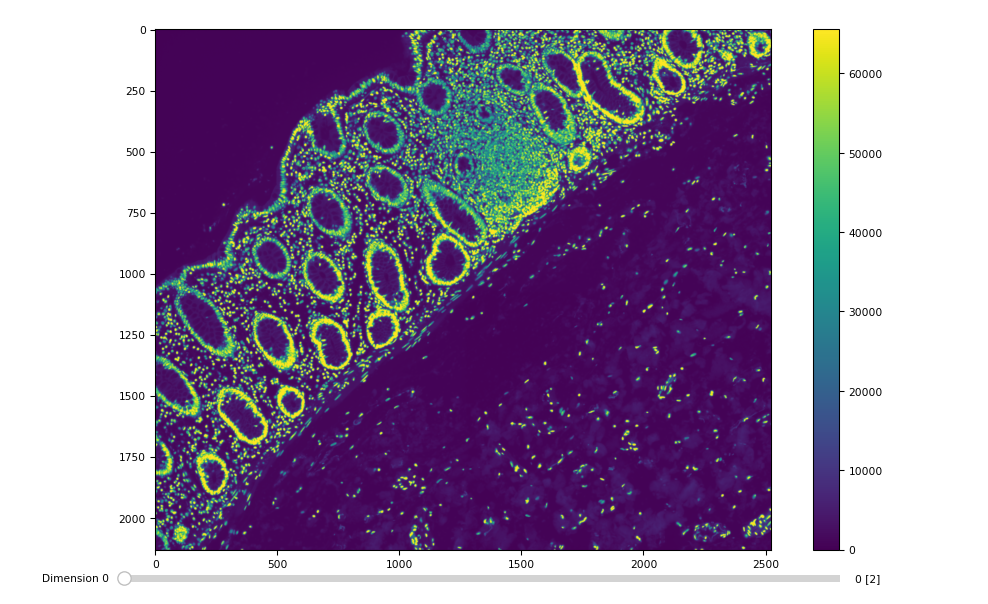

In [ ]:
# %matplotlib ipympl

im = da.concatenate([fused_sims[cycle][0] for cycle in cycles], axis=-3)

tifffile.imshow(
    # im[:, :100, :100],
    im[:],
    photometric=1
    )

In [ ]:
# save to one single zarr

# with diagnostics.ProgressBar():
#     f = da.to_zarr(
#         im,
#         'f.zarr',
#         return_stored=True,
#         overwrite=True,
#     )

[########################################] | 100% Completed | 1.36 sms
